In [60]:
import numpy as np
import matplotlib.pyplot as plt
import maxflow
from math import sqrt
import h5py

import pandas

import networkx as nx
import scipy.sparse as sp

In [61]:
from diffpy.structure import Atom, Lattice, Structure
from orix import plot
from orix.crystal_map import CrystalMap, Phase, PhaseList
from orix.io import load, save
from orix.quaternion import Orientation, Rotation, symmetry, Misorientation
from orix.vector import Vector3d

In [62]:
from loadAng import loadAng, getLibraryPhaseList
from full_from_diag import full_from_diag

In [63]:
xmap = load('data/AF_001.hdf5')
xmap.size

103041

In [94]:
oMap = xmap.rotations
oMap[0]
xmap.id

array([     0,      1,      2, ..., 103038, 103039, 103040])

In [93]:
active_xmap = xmap[xmap.phases[2].name]
print(active_xmap.phases)

Id          Name  Space group  Point group  Proper point group       Color
-1   not_indexed         None         None                None           w
 1  b'Austenite'         None          432                 432  tab:orange
 2   b'\x80\xbf'         None          432                 432    tab:blue


In [65]:
file = "data/AF_001.hdf5"
f = h5py.File(file, 'r')
group = f['crystal_map']['data']
gKeys = list(group.keys())
euler1, euler2, euler3  = np.asarray(group['phi1']), np.asarray(group['Phi']), np.asarray(group['phi2']) # bunge convention
x, y, z = np.asarray(group['x']), np.asarray(group['y']), np.asarray(group['z'])
iq, ci, phase_id, ids, fit, is_in_data  = np.asarray(group['iq']), np.asarray(group['ci']), np.asarray(group['phase_id']), np.asarray(group['id']), np.asarray(group['fit']), np.asarray(group['is_in_data']) # i can't believe you looked all the way over here
f.close()
#%%
# Create a Rotation object from Euler angles
euler_angles = np.column_stack((euler1, euler2, euler3))
rotations = Rotation.from_euler(euler_angles)
# Create a property dictionary
properties = dict(iq=iq, dp=ci)
# Create unit cells of the phases
structures = [
    Structure(
        title="austenite",
        atoms=[Atom("fe", [0] * 3)],
        lattice=Lattice(0.360, 0.360, 0.360, 90, 90, 90)
    ),
    Structure(
        title="ferrite",
        atoms=[Atom("fe", [0] * 3)],
        lattice=Lattice(0.287, 0.287, 0.287, 90, 90, 90)
    )
]
phase_list = PhaseList(
    names=["austenite", "ferrite"],
    point_groups=["432", "432"],
    structures=structures,
)
# Create a CrystalMap instance
xmap2 = CrystalMap(
    rotations=rotations,
    phase_id=phase_id,
    x=x,
    y=y,
    phase_list=phase_list,
    prop=properties,
)
xmap2.scan_unit = "um"
#%%
ckey_m3m = plot.IPFColorKeyTSL(xmap2.phases[1].point_group, direction=Vector3d.zvector())
rgb_au = ckey_m3m.orientation2color(xmap2["austenite"].orientations)
rgb_fe = ckey_m3m.orientation2color(xmap2["ferrite"].orientations)

In [66]:
GRID = 'SqrGrid'
NROWS = 321
NCOLS_ODD = 321

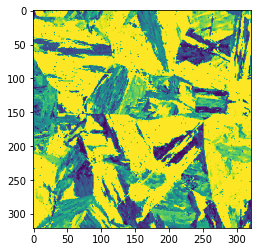

In [67]:
################################
### start building structure to feed into network
### build square array of hex grid points for graph cut
### populate pixels with R channel of orientation image
### leave non-indexed or other phases as zeros

# if GRID == 'HexGrid':

#     nodeDataArr = np.zeros((NROWS, NCOLS_ODD))

#     cRow = 0
#     cID = 0

#     for pair in np.arange(int(NROWS/2)):

#         nodeDataArr[cRow, :NCOLS_EVEN] = rgb_fe[cID:cID+NCOLS_EVEN][:,0] ### even
#         cRow += 1
#         cID = cID+NCOLS_EVEN

#         nodeDataArr[cRow, :NCOLS_ODD] = rgb_fe[cID:cID+NCOLS_ODD][:,0] ### odd
#         cRow += 1
#         cID = cID+NCOLS_ODD

#         # print(cRow, pair)

#     plt.imshow(nodeDataArr)
#     axes=plt.gca()
#     axes.set_aspect(0.5)
#     plt.show()

if GRID == 'SqrGrid':
    ### squaregrid data for graphcut

    nodeData2 = np.zeros((xmap2.id.shape[0], 1))
    ferriteIDs =  xmap2['ferrite'].id
    ferriteGray = rgb_fe[:,0]
    failCounter = 0

    for i in xmap2.id:
        # print(i)
        try:
            # print(i)
            idx = np.where(ferriteIDs == i)[0][0]
            nodeData2[i] = ferriteGray[idx]
        except:
            # print('no value', failCounter)
            failCounter += 1

    n = np.round(sqrt(xmap2.id.shape[0])).astype(int)
    nodeDataArr = np.reshape(nodeData2, (n,n))

    plt.imshow(nodeDataArr)
    plt.show()

In [68]:
### start graphcut

ip_weight = 0.01 ### max > ip_weight > min of data as a place to start

g = maxflow.GraphFloat()
if GRID == 'HexGrid':
    nodeids = g.add_grid_nodes((NROWS, NCOLS_ODD))
    structure = np.array([[0, 1, 1],
                      [1, 0, 1],
                      [0, 1, 1]]) ### struct for hex grid
elif GRID == 'SqrGrid':
    nodeids = g.add_grid_nodes((n,n))
    # structure = maxflow.vonNeumann_structure(ndim=2, directed=True) ### square grid structure
    structure = np.array([[0, 1, 0],
                          [1, 0, 1],
                          [0, 1, 0]]) ### struct for square grid
    
g.add_grid_edges(nodeids, ip_weight, structure=structure)
g.add_grid_tedges(nodeids, nodeDataArr, 1-nodeDataArr)


In [69]:

#%% get connectivity information from network
C = g.get_nx_graph()

adj_arr = nx.to_scipy_sparse_array(C) # turn into sparse array (for space)
sparseUpperArr = sp.triu(adj_arr) # gets upper diagonal of array to save space

u,v,wt = sp.find(sparseUpperArr) # gets node to node connections and weights
connectivity = np.asanyarray([u,v]) # extract just the node connections

#%%
sink = np.amax(connectivity.ravel())
source = sink-1
source_edges = np.any(connectivity==source,axis=0)
sink_edges = np.any(connectivity==sink, axis=0)
out_plane_loc = np.any(np.vstack([source_edges, sink_edges]), axis=0)
connectivity2 = connectivity[:, ~out_plane_loc] # adjacency matrix without source and sink connections
                                                # (in-plane connections)
connectTerminal = connectivity[:, out_plane_loc]

#%% Calculate misorientations for in-plane weights

#m = (~o1).outer(o2) # from orix documentation, but slow and has memory problems
o1 = xmap2.rotations[connectivity2[0,:]] # orientation of node u
o2 = xmap2.rotations[connectivity2[1,:]] # orientation of node v
m = Misorientation(o1*o2.conj).to_euler() # misorientations between every u and v
# m.symmetry = (symmetry.Oh, symmetry.Oh) # 'Oh' is symmetry (need to un-hard code)
# m2 = m.map_into_symmetry_reduced_zone() 

# misori_angles = m2.angle

In [70]:
allO = xmap2.rotations # orientation of node u
# o2 = xmap2.rotations[connectivity2[1,:]] # orientation of node v
m2 = Misorientation(allO*allO[4044].conj).to_euler() # misorientations between every u and v

In [71]:
ipDict = {'ip_w': m, 'connections': connectivity2}
opDict = {'op_w': m2, 'nodes': xmap2.id}

In [72]:
from scipy.io import savemat

savemat('data/ipDict.mat', ipDict)
savemat('data/opDict.mat', opDict)

In [73]:
from scipy.io import loadmat

data_p = 'data/ipw_w.mat'
mat_data = loadmat(data_p)
ip_weights = mat_data['ipw_w'] # or 'ipw_w'
ip_weights = ip_weights.T

data_p = 'data/opw_w.mat'
mat_data = loadmat(data_p)
op_weights = mat_data['opw_w'] # or 'ipw_w'
op_weights = op_weights.T

In [74]:
ip_weights = ip_weights

In [75]:
op_weights_arr = np.reshape(op_weights, (NROWS, NCOLS_ODD))
sink_weights = np.zeros_like(op_weights_arr)*np.mean(op_weights_arr)

In [76]:
from full_from_diag import full_from_diag

updated_ip_weights = sp.csr_array(adj_arr)
updated_ip_weights[connectivity2[0,:],connectivity2[1,:]] = ip_weights[:] #assign misorientations as new weights to original nodes
                                                                # not sure why it gives two rows for misori
# Return sparse matrix to networkx format
updated_nxgraph = nx.from_scipy_sparse_array(updated_ip_weights) # new adjacency array with misori weights
updated_nxgraph = full_from_diag(sp.triu(updated_ip_weights))


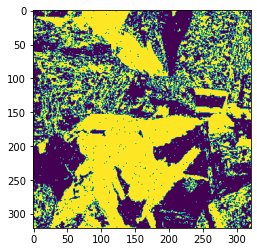

In [77]:
#%% populate network through pymaxflow
mister = maxflow.GraphFloat()
n_ids = mister.add_grid_nodes((NROWS, NCOLS_ODD)) 

for i in range(len(updated_nxgraph)):
    uu,vv, mwt = updated_nxgraph[i, 0], updated_nxgraph[i,1], updated_nxgraph[i,2]
    if (uu>=sink or vv>=sink)==False:
        mister.add_edge(int(uu),int(vv),mwt,mwt)

mister.add_grid_tedges(n_ids, op_weights_arr, 1/op_weights_arr)
mister.maxflow()
sgm = mister.get_grid_segments(n_ids)
img3 = np.int_(np.logical_not(sgm))
from matplotlib import pyplot as ppl
ppl.figure("first")
ppl.imshow(img3)
ppl.show()

In [78]:
sgm

array([[False, False,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       ...,
       [False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False,  True,  True]])

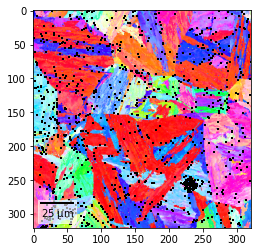

In [62]:
ckey_m3m = plot.IPFColorKeyTSL(xmap2.phases["austenite"].point_group, direction=Vector3d.zvector())
rgb_au = ckey_m3m.orientation2color(xmap2["austenite"].orientations)
rgb_fe = ckey_m3m.orientation2color(xmap2["ferrite"].orientations)

xmap2['ferrite'].plot(rgb_fe)

In [73]:
print(xmap2['ferrite'].id[4000:5000])

[4039 4040 4041 4042 4043 4044 4045 4046 4047 4048 4049 4050 4051 4052
 4053 4054 4055 4056 4057 4058 4059 4060 4061 4062 4063 4064 4065 4066
 4067 4068 4069 4070 4071 4072 4073 4074 4075 4076 4077 4078 4079 4080
 4081 4082 4083 4084 4085 4086 4087 4088 4089 4090 4091 4092 4093 4094
 4095 4096 4097 4098 4099 4100 4101 4102 4103 4104 4105 4106 4107 4108
 4109 4110 4111 4112 4113 4114 4115 4116 4117 4118 4119 4120 4121 4122
 4123 4124 4125 4126 4127 4128 4129 4130 4131 4132 4133 4134 4135 4137
 4138 4139 4140 4141 4142 4143 4144 4145 4146 4147 4148 4149 4150 4151
 4152 4153 4154 4155 4156 4157 4158 4159 4160 4161 4162 4163 4164 4165
 4166 4167 4168 4169 4170 4171 4172 4173 4174 4175 4176 4177 4178 4179
 4180 4181 4182 4183 4184 4185 4186 4187 4188 4189 4190 4191 4192 4193
 4194 4195 4196 4197 4198 4199 4200 4201 4202 4203 4204 4205 4206 4207
 4208 4209 4210 4211 4212 4213 4214 4215 4216 4217 4218 4219 4220 4221
 4222 4223 4224 4225 4226 4227 4228 4230 4231 4232 4233 4234 4235 4236
 4237 

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 18 09:45:34 2022
@author: agerlt
"""
from orix.io import load
from scipy.spatial.transform import Rotation as R
from orix.quaternion import Rotation as Rotation
from orix.quaternion import Orientation, symmetry, Symmetry
from temp_functions import yardley_variants
import os
import numpy as np
# get yardley variants as orix rotation objects
ksi = 'ks'
yv_payton = yardley_variants('ks')
yv = Rotation(np.vstack([Rotation.from_matrix(
    np.vstack(yv_payton[i])
    ).data for i in range(yv_payton.shape[0])]))
# LOAD EBSD
Data_loc = os.sep.join("/Data/EBSD/AF96_321x/AF_001.ang".split("/"))
load_path = os.sep.join(os.getcwd().split(os.sep)[:-1]) + Data_loc
ebsd = load(load_path)
# Fix stupid names
ebsd.phases[1].name = 'Aust'
ebsd.phases[2].name = 'Mart'
# pick an id randomly that is martensite
guess_id = ebsd['Mart'].id[np.random.randint(ebsd['Mart'].id.size)]
guess_ori = ebsd[ebsd.id == guess_id].orientations
inv_guess_ori = Orientation(guess_ori.conj,symmetry.O)
# rotate everything by that guess_ori
rotated_mart = ebsd['Mart'].orientations *inv_guess_ori
# Find the distance between those rotated orientations and the variants
all_misos = rotated_mart.angle_with_outer(Orientation(yv,symmetry.O))
# Pick the min
misos = np.min(all_misos, axis = 1)
# turn that into a likelyhood. This assumes the orientation spread is perfectly
# symmetric( it isn't), and that this is the correct de la valle Poisson 
# equation (it might be). It will get you close though.
hw = 2*np.pi/180
likelyhood = np.log(0.5**0.5)/np.log(np.cos(misos*hw/2))
like_map = np.zeros([321*321])
like_map[ebsd['Mart'].id] = likelyhood
like_map = np.log(like_map.reshape(321,321))
#scipy_oris = R.from_euler('ZXZ',orix_oris.as_euler())